- **Name**: Saher Saeed  
- **Student ID**: 23095056  
- **GitHub Repository**: [Model-Comparison-Repo](https://github.com/saeedsahar/svn-random-decision-repo.git)


# Apartment for Rent Classified

This notebook analyzes the **Apartment for Rent Classified** dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/apartment+for+rent+classified).

- **Source**: UCI Machine Learning Repository  
- **Data type**: Tabular data containing apartment rental listings and attributes  
- **Features**: Include number of bedrooms, bathrooms, square footage, furnishing status, amenities (elevator, parking, security), and location info  
- **Target**: Classification of apartment listings, possibly based on rent level or type  
- **Purpose**: To predict apartment rental categories based on listing attributes and analyze key factors influencing rental classification

---

## Data Card

| Property               | Details                                         |
|------------------------|--------------------------------------------------|
| **Dataset Name**       | Apartment for Rent Classified                   |
| **UCI ID**             | 555                                             |
| **Total Rows**         | 99826       |
| **Total Columns**      | 21        |
| **Data Type**          | Tabular (Structured)                            |
| **Target Variable**    | Rental Category/Class                           |
| **Missing Values**     | To be checked                                   |
| **Source**             | [UCI Repository Link](https://archive.ics.uci.edu/ml/datasets/apartment+for+rent+classified) |

---

## Variable Overview

The table below lists all features (input variables) in the dataset, along with their data types and descriptions (if provided).

| Column Name       | Data Type | Description                       |
|-------------------|-----------|-----------------------------------|
| `bedrooms`        | Numeric   | Number of bedrooms                |
| `bathrooms`       | Numeric   | Number of bathrooms               |
| `square_feet`     | Numeric   | Area in square feet               |
| `furnishing`      | Categorical | Furnishing status (furnished/unfurnished) |
| `location`        | Categorical | Location or region                |
| `elevator`        | Binary    | Presence of elevator (0/1)        |
| `parking`         | Binary    | Availability of parking (0/1)     |
| `security`        | Binary    | Presence of security (0/1)        |
| `latitude`        | Numeric   | GPS Latitude                      |
| `longitude`       | Numeric   | GPS Longitude                     |
| `price`           | Numeric   | Rental price                      |
| `time`            | Numeric   | Timestamp or time-related metric  |
| `target`          | Categorical | Rental category/class label      |

> *Note: Update column descriptions based on `apartment_for_rent_classified.variables` if you want full accuracy.*

---

**Citation**:  
> Tareq Nasir and Saeed Aljahdali. An Intelligent System for Predicting Apartment for Rent Category Using Machine Learning Algorithms. *International Journal of Advanced Computer Science and Applications*, Vol. 13, No. 8, 2022.  
> DOI: 10.14569/IJACSA.2022.0130882


In [129]:
# === Data & Utilities ===
import pandas as pd
import numpy as np
import zipfile, requests, io
from ucimlrepo import fetch_ucirepo
from tabulate import tabulate
import time

# === Statistics & Distributions ===
from scipy.stats import kurtosis, skew

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# === Scikit-learn Core ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Models ===
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)


##  Load Dataset from UCI Repository

We use the `ucimlrepo` Python package to fetch the **Apartment for Rent Classified** dataset directly from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/apartment+for+rent+classified).




In [130]:

apartment_for_rent_classified = fetch_ucirepo(id=555) 
  
# data (as pandas dataframes) 
X = apartment_for_rent_classified.data.features 
y = apartment_for_rent_classified.data.targets 
  
# metadata 
print(apartment_for_rent_classified.metadata) 
  
# variable information 
print(apartment_for_rent_classified.variables) 
X.count()
X.shape[0]
X.shape[1]


{'uci_id': 555, 'name': 'Apartment for Rent Classified', 'repository_url': 'https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified', 'data_url': 'https://archive.ics.uci.edu/static/public/555/data.csv', 'abstract': 'This is a dataset of classified for apartments for rent in USA.\n', 'area': 'Business', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 10000, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': None, 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5X623', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "The dataset contains of 10'000 or 100'000 rows and of 22 columns The data has been cleaned in the way that \r\ncolumn price and square_feet never is empty but the dataset is saved as it was created.\r\n\r\n

/opt/anaconda3/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


21

##  Data Cleaning: Handling Duplicates, Missing Values, Type Conversion and Outliers


In [131]:
# Combine them for a full dataset
df = pd.concat([X, y], axis=1)

In [132]:
# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

In [133]:
# Drop rows with missing values
df.dropna(inplace=True)

In [134]:
# Store a copy before outlier removal
df_before_outliers = df.copy()

In [135]:
def remove_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply the function
df_after_outliers = remove_outliers_iqr(df)

In [136]:
# Convert eligible columns to numeric if possible
for col in df_before_outliers.columns:
    if df_before_outliers[col].dtype == 'object':
        try:
            df_before_outliers[col] = pd.to_numeric(df_before_outliers[col])
            df_after_outliers[col] = pd.to_numeric(df_after_outliers[col])
        except:
            continue

# Get only numeric columns
numerical_cols = df_before_outliers.select_dtypes(include=[np.number]).columns
print(numerical_cols)

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'time'],
      dtype='object')


##  Outlier Detection: Before vs After

The box plots below show a side-by-side comparison of numerical features **before and after outlier removal**.

- **Left plot**: Original data with potential outliers.
- **Right plot**: Cleaned data after removing extreme values.

Using soothing pastel colors, these visualizations help us clearly see how outlier treatment affects the distribution of each feature. This step ensures the data is more consistent and less skewed, improving model performance and interpretability.


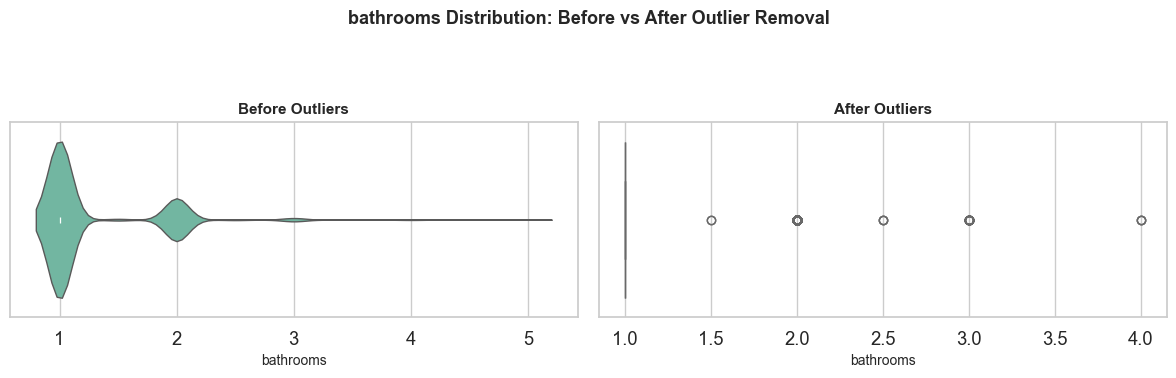

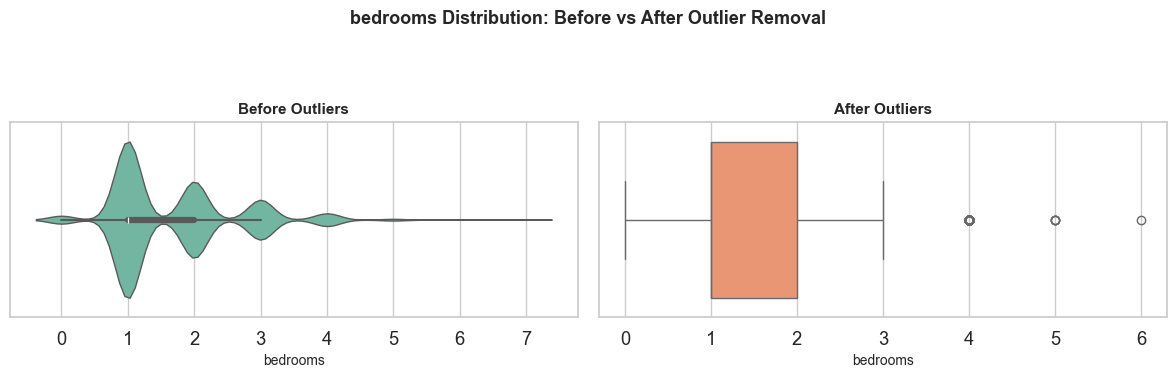

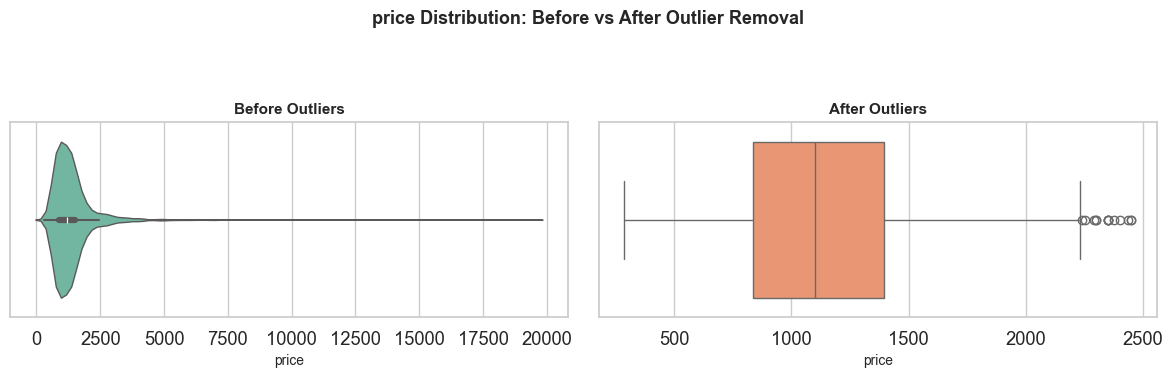

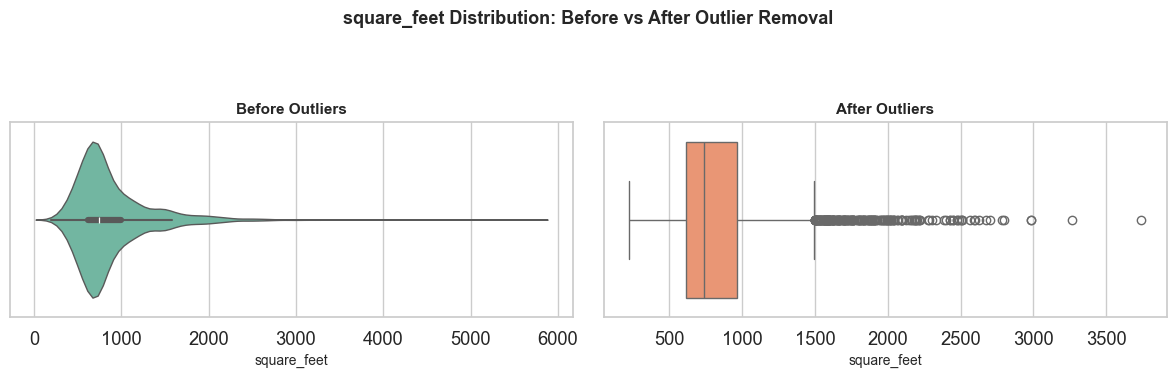

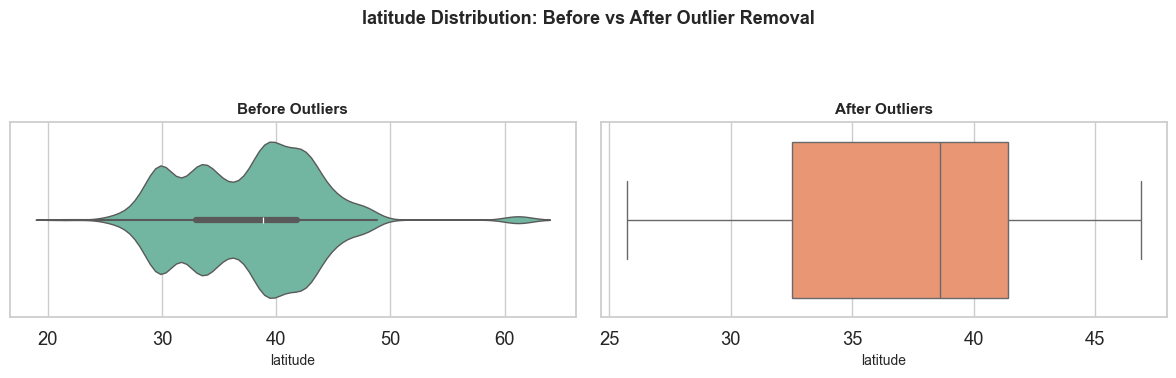

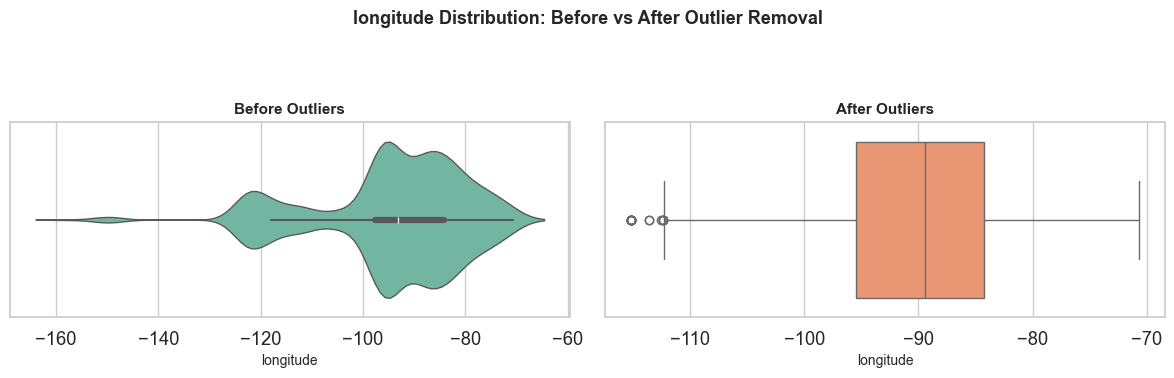

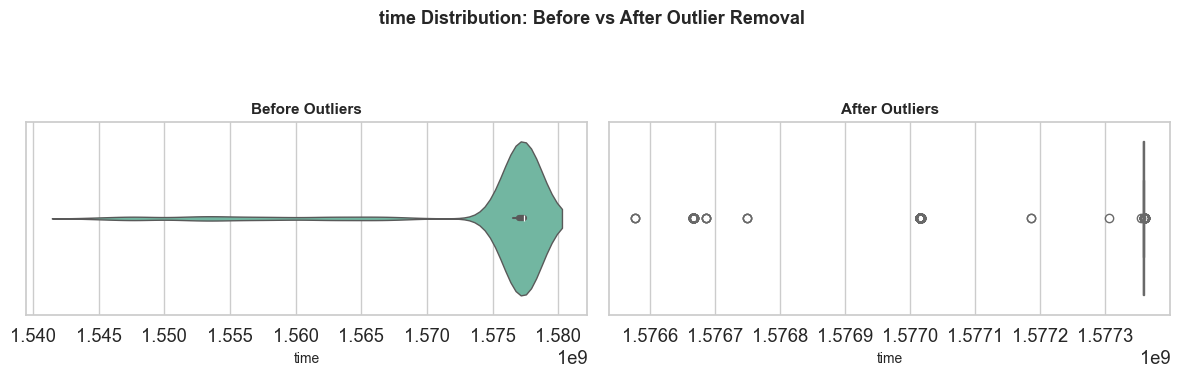

In [137]:


# Better color theme
sns.set_style("whitegrid")
custom_palette = sns.color_palette("Set2")  # Try "husl" or "colorblind" for other vibes

# Loop through each numerical column
for col in numerical_cols:
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Violin plot (Before Outliers)
    ax0 = plt.subplot(gs[0])
    sns.violinplot(
        x=df_before_outliers[col],
        ax=ax0,
        inner="box",  # keeps a small boxplot inside
        linewidth=1,
        color=custom_palette[0]
    )
    ax0.set_title("Before Outliers", fontsize=11, fontweight='semibold')
    ax0.set_xlabel(col, fontsize=10)

    # Boxplot (After Outliers)
    ax1 = plt.subplot(gs[1])
    sns.boxplot(
        x=df_after_outliers[col],
        ax=ax1,
        linewidth=1,
        color=custom_palette[1]
    )
    ax1.set_title("After Outliers", fontsize=11, fontweight='semibold')
    ax1.set_xlabel(col, fontsize=10)

    # Main title
    plt.suptitle(f"{col} Distribution: Before vs After Outlier Removal", fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()


In [138]:
# Basic statistics on numerical columns only
desc_stats = df_after_outliers[numerical_cols].describe(percentiles=[]).T
# Drop the 50% (median) row
desc_stats = desc_stats.drop(columns='50%')

# Add skewness and kurtosis
desc_stats['skewness'] = df_after_outliers[numerical_cols].skew()
desc_stats['kurtosis'] = df_after_outliers[numerical_cols].kurtosis()

# Generate tabulated view of descriptive statistics
tabulated_stats = tabulate(desc_stats.reset_index(), headers='keys', tablefmt='grid', showindex=False)

# Display the formatted table
print(tabulated_stats)


+-------------+---------+----------------+---------------+----------------+----------------+------------+------------+
| index       |   count |           mean |           std |            min |            max |   skewness |   kurtosis |
+=============+=========+================+===============+================+================+============+============+
| bathrooms   |    2109 |    1.23305     |      0.465461 |    1           |    4           |   1.89463  |  3.33196   |
+-------------+---------+----------------+---------------+----------------+----------------+------------+------------+
| bedrooms    |    2109 |    1.66714     |      0.931306 |    0           |    6           |   1.05549  |  0.324267  |
+-------------+---------+----------------+---------------+----------------+----------------+------------+------------+
| price       |    2109 | 1138.21        |    375.209    |  288           | 2450           |   0.596766 |  0.0478964 |
+-------------+---------+----------------+------

##  Correlation Matrix of Numerical Features

The heatmap below shows the **Pearson correlation coefficients** between all numerical features in the dataset.

- Values range from **-1 to +1**:
  - `+1`: Perfect positive correlation
  - `-1`: Perfect negative correlation
  - `0`: No linear correlation

### Key Observations:
- `square_feet` is highly correlated with both `bathrooms` (0.78) and `bedrooms` (0.72), suggesting that larger apartments typically have more rooms.
- `price` has moderate correlations with `square_feet` (0.39), `bathrooms`, and `bedrooms` (both 0.32).
- `latitude`, `longitude`, and `time` show minimal correlation with most other features, indicating spatial and temporal independence in pricing or size.

This matrix helps identify multicollinearity and informs feature selection for modeling.


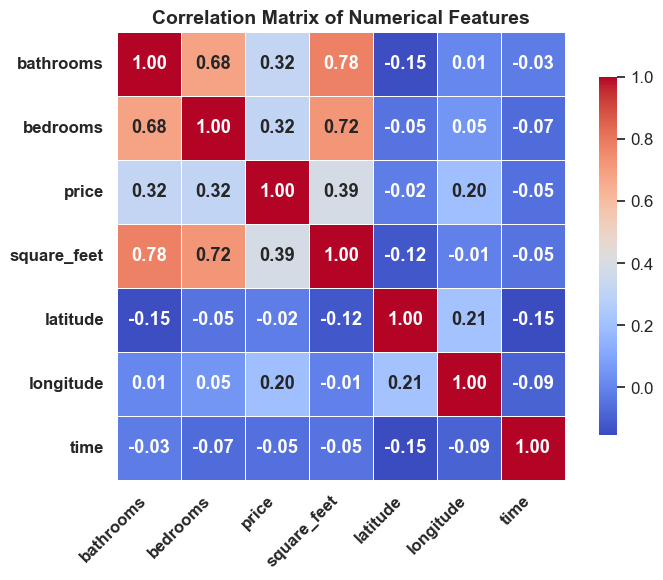

In [139]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = df_after_outliers[numerical_cols].corr()

# Enhanced heatmap with bolded text and cropped visual layout
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)

heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    annot_kws={"weight": "bold"},
    cbar_kws={"shrink": 0.8}
)

# Bold axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), weight='bold', rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), weight='bold', rotation=0)

plt.title("Correlation Matrix of Numerical Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


##  Distribution of Numerical Features

The histograms below display the distribution of each numerical feature in the dataset. These visualizations help identify data skewness, modality, and potential outliers.

### Key Insights:
- **price** and **square_feet** show strong right-skewness, indicating most listings fall on the lower end with a few high-value outliers.
- **bedrooms** appears to have a multimodal distribution, reflecting common apartment configurations (e.g., 1BHK, 2BHK, etc.).
- **latitude** and **longitude** exhibit distinct location-based clusters, likely corresponding to different regions or cities.
- **time** shows a spike at the end, possibly indicating a batch of recent listings or timestamp artifacts.

These distributions guide data transformation steps like normalization or log-scaling for improved model performance.


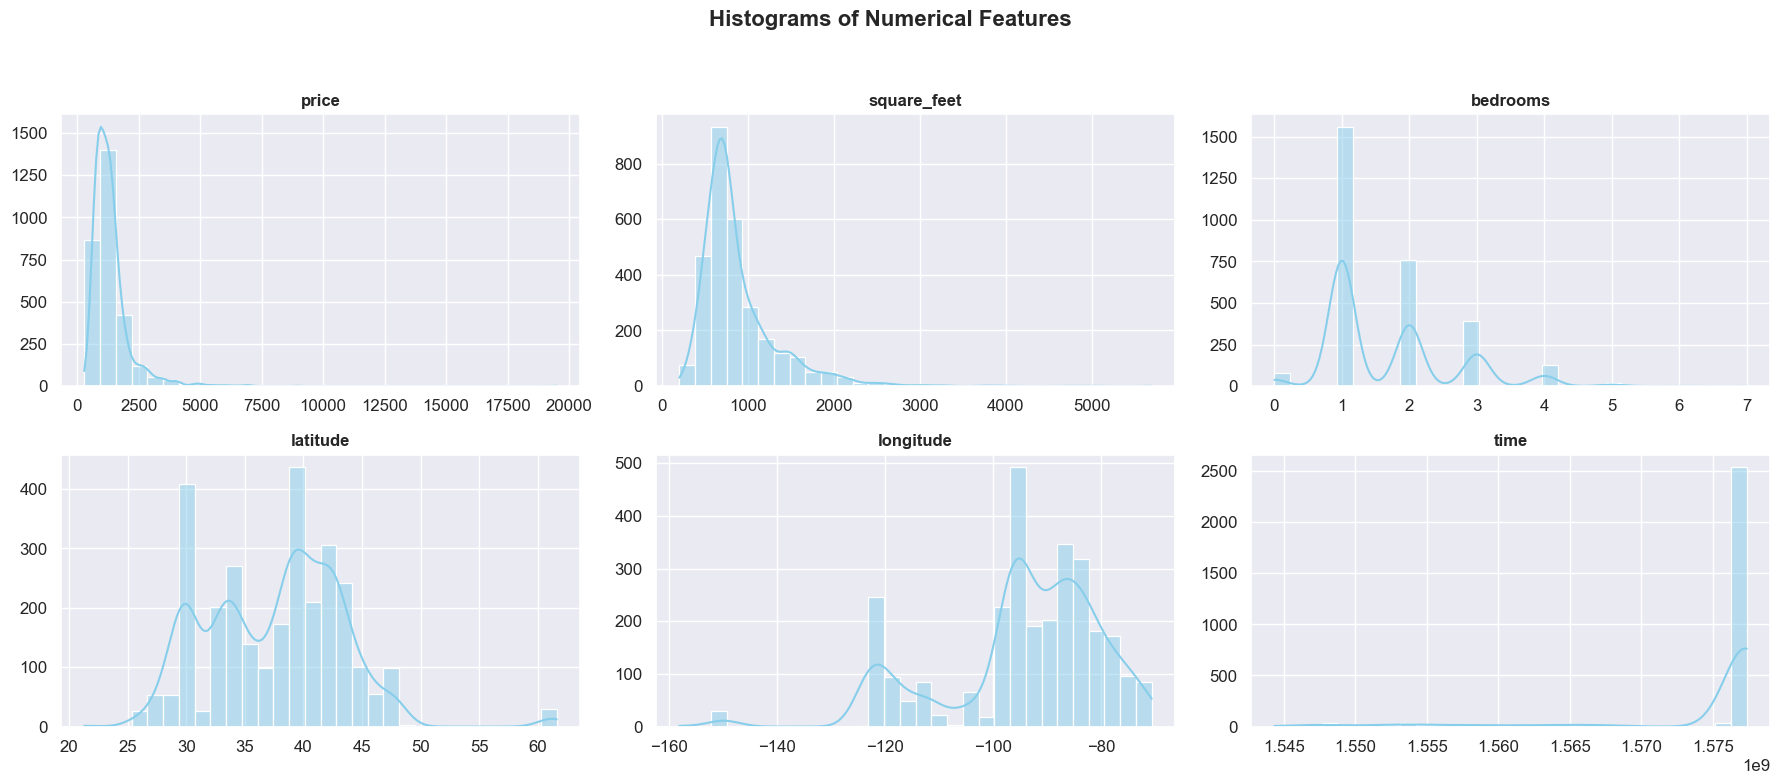

In [140]:
# Convert numerical columns to appropriate types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['square_feet'] = pd.to_numeric(df['square_feet'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['time'] = pd.to_numeric(df['time'], errors='coerce')

# Drop any new NaNs from conversion
df.dropna(inplace=True)

# Define numerical columns
numerical_cols = ['price', 'square_feet', 'bedrooms', 'latitude', 'longitude', 'time']

# Concise grid of histograms
cols_per_row = 3
rows = (len(numerical_cols) + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4 * rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Remove any empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##  Average Rent Price by State

The bar chart below shows the **average rental price** across U.S. states, with **listing counts labeled on top of each bar**.

### Key Insights:
- **Hawaii (HI)** and **California (CA)** have the highest average rents, reflecting the premium cost of living in these states.
- **New York (NY)**, **Massachusetts (MA)**, and **Washington D.C.** also rank high in average rent.
- States like **Mississippi (MS)**, **North Dakota (ND)**, and **Wyoming (WY)** have the **lowest average rents**, often paired with fewer listings.
- The number on each bar represents the **number of listings** considered for that state, providing context on data reliability (e.g., high rent in HI is based on just 3 listings).
- * A red asterisk above the bar indicates the state has fewer than 5 listings, and therefore its average rent value may not be statistically reliable.

This chart helps identify regional pricing patterns and supports geographic segmentation for rental market analysis.


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_72863/4162863969.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_stats, x='state', y='mean', palette='coolwarm', edgecolor='black')


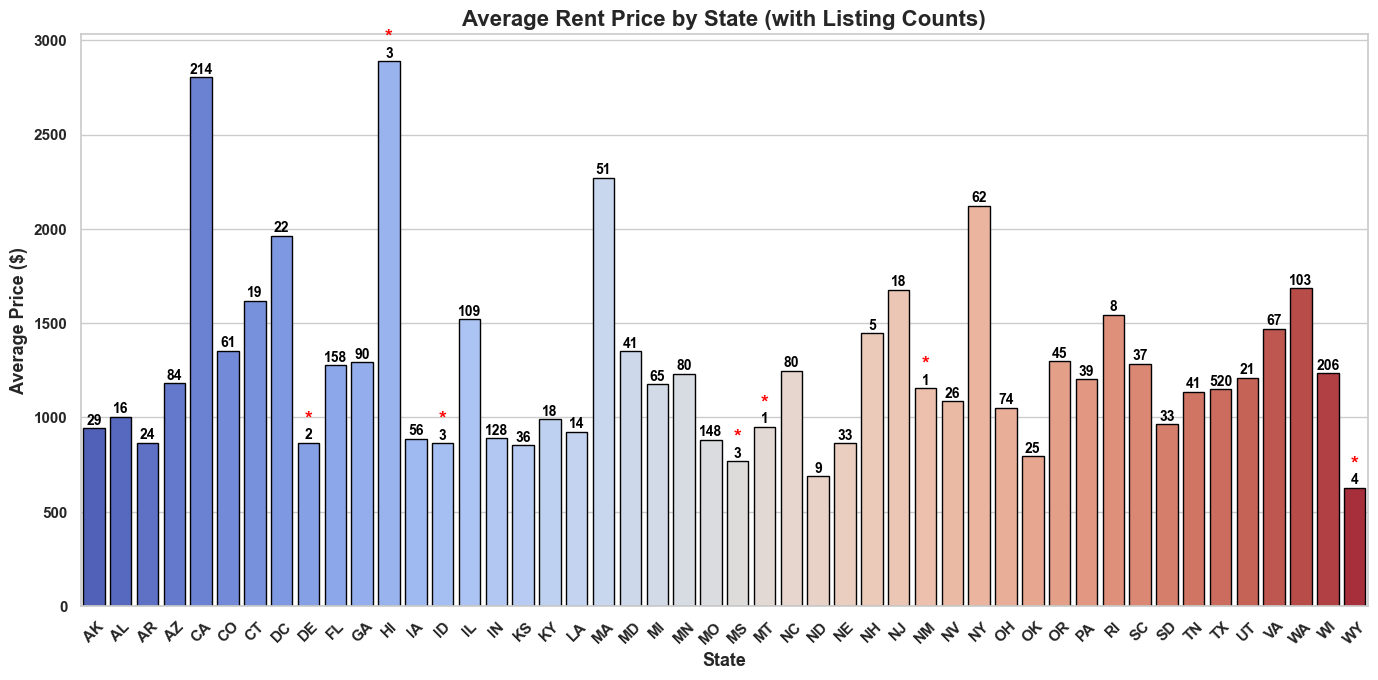

In [141]:
# Calculate average rent price and listing count by state
state_stats = df.groupby('state').agg(mean=('price', 'mean'), count=('price', 'size')).reset_index()

# Enhanced bar plot: Average rent price by state with annotations
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.barplot(data=state_stats, x='state', y='mean', palette='coolwarm', edgecolor='black')

# Title and axis labels
plt.title("Average Rent Price by State (with Listing Counts)", fontsize=16, fontweight='bold')
plt.xlabel("State", fontsize=13, fontweight='bold')
plt.ylabel("Average Price ($)", fontsize=13, fontweight='bold')
plt.xticks(rotation=45, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')

# Annotate each bar with listing count
for index, row in state_stats.iterrows():
    y = row['mean']
    count = int(row['count'])
    
    # Listing count annotation
    plt.text(index, y + 20, f"{count}", 
             ha='center', fontsize=10, fontweight='bold', color='black')
    
    # Add red asterisk if listing count < 5
    if count < 5:
        plt.text(index, y + 100, "*", 
                 ha='center', fontsize=14, fontweight='bold', color='red')

plt.tight_layout()
plt.show()


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_72863/2923379620.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


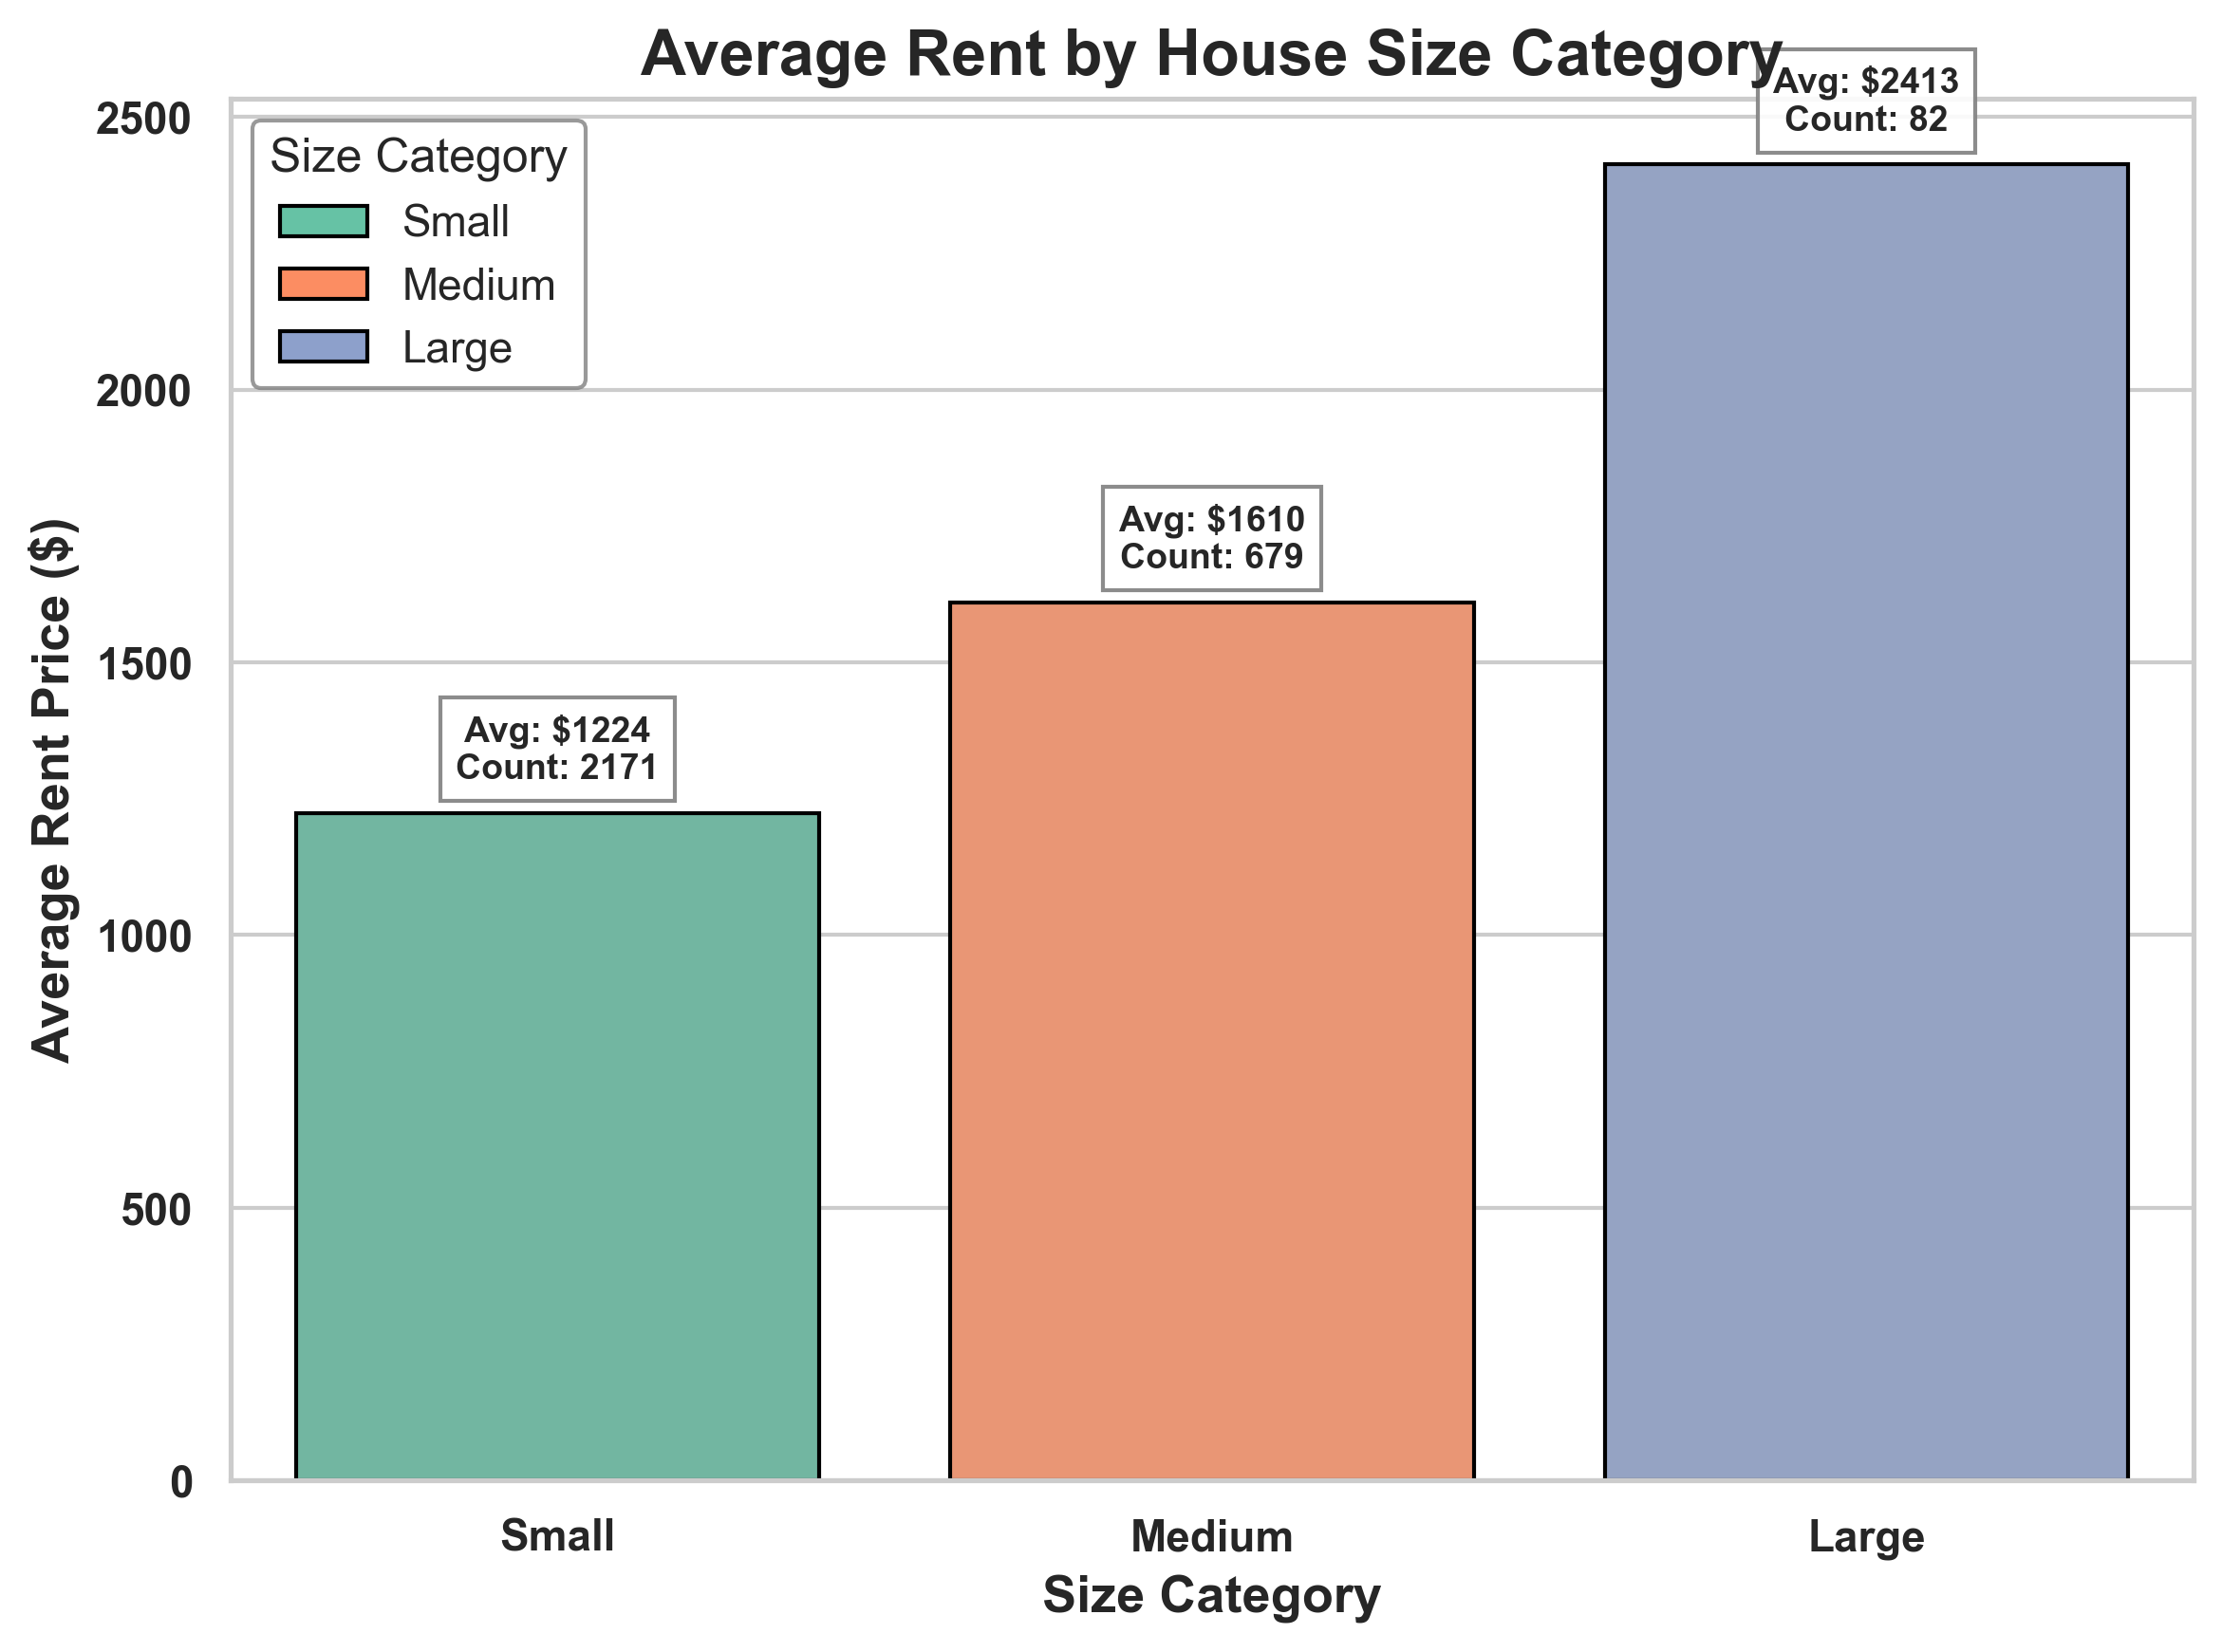

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Categorize house sizes
def categorize_sqft(sqft):
    if sqft < 1000:
        return 'Small'
    elif sqft <= 2000:
        return 'Medium'
    else:
        return 'Large'

df['Size Category'] = df['square_feet'].apply(categorize_sqft)

# Step 2: Compute stats
stats = df.groupby('Size Category')['price'].agg(['count', 'mean']).reindex(['Small', 'Medium', 'Large']).reset_index()

# Step 3: Bar plot
plt.figure(figsize=(8, 6), dpi=300)
sns.set_style("whitegrid")
barplot = sns.barplot(
    data=stats,
    x='Size Category',
    y='mean',
    palette='Set2',
    edgecolor='black'
)

# Step 4: Annotations on bars
for i, row in stats.iterrows():
    label = f"Avg: ${row['mean']:.0f}\nCount: {int(row['count'])}"
    plt.text(
        i,
        row['mean'] + 50,  # slightly above the bar
        label,
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.9)
    )

# Labels & title
plt.title("Average Rent by House Size Category", fontsize=16, fontweight='bold')
plt.xlabel("Size Category", fontsize=13, fontweight='bold')
plt.ylabel("Average Rent Price ($)", fontsize=13, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')

# Step 5: Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=sns.color_palette('Set2')[0], edgecolor='black', label='Small'),
    Patch(facecolor=sns.color_palette('Set2')[1], edgecolor='black', label='Medium'),
    Patch(facecolor=sns.color_palette('Set2')[2], edgecolor='black', label='Large')
]
plt.legend(
    handles=legend_elements,
    title='Size Category',
    title_fontsize=12,
    fontsize=11,
    loc='upper left',
    frameon=True,
    edgecolor='gray'
)

plt.tight_layout()
plt.show()


## Daily Average Rent Price Over Time

The line plot below illustrates the **daily average rent price** throughout the year **2019**.

### Key Observations:
- The rent prices show **high variability** across days, with several noticeable peaks and drops.
- A sharp spike around **mid-2019** indicates either an outlier listing or a surge in high-priced rentals on that specific day.
- There are periods of relative stability, especially toward the end of the year, where fluctuations decrease.

This visualization helps reveal **temporal patterns** in rental pricing and can inform decisions related to **seasonality**, **anomaly detection**, or **trend analysis**.


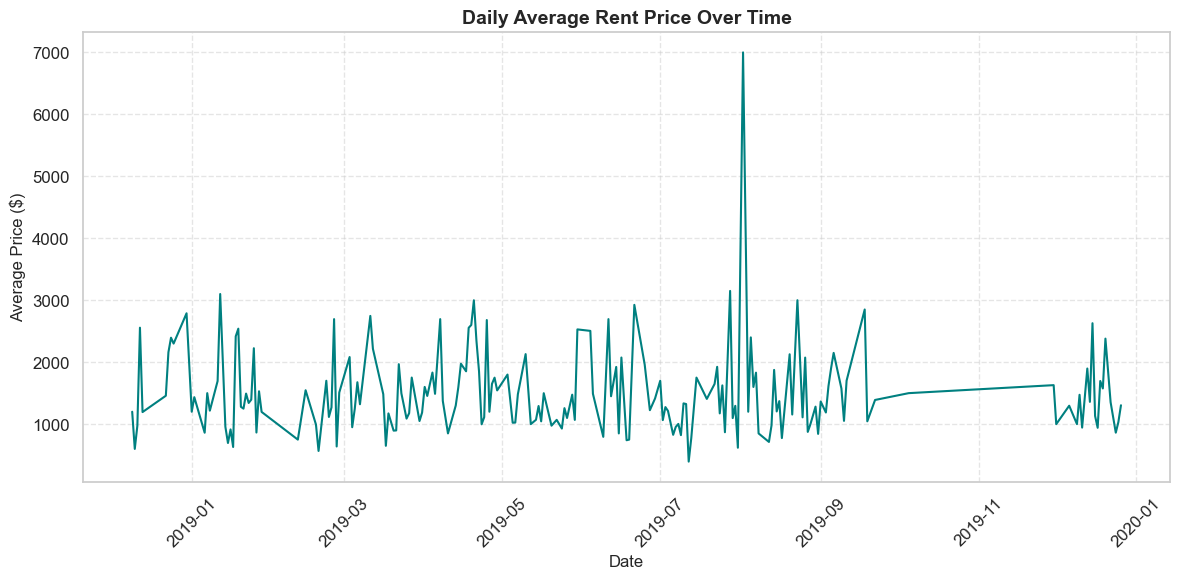

In [143]:
# Convert 'time' from Unix timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')

# Create a new column for date (without time)
df['date'] = df['time'].dt.date

# Group by date and calculate mean price per day
daily_price_trend = df.groupby('date')['price'].mean().reset_index()

# Plotting the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_price_trend, x='date', y='price', color='teal')
plt.title("Daily Average Rent Price Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##  Model Performance Comparison

Three machine learning models were trained and evaluated to classify apartment rent categories:

- **Support Vector Machine (SVM)**
- **Random Forest**
- **Decision Tree**

###  Summary:

- **SVM** showed limited performance, indicating underfitting.
- **Random Forest** performed the best, offering strong generalization and balanced classification.
- **Decision Tree** performed well but showed signs of overfitting.

Among the three, **Random Forest** proved to be the most effective for this classification task.


In [144]:


# Prepare dataset: Predict if price is above median
df_model = df_after_outliers.copy()
df_model['price_above_median'] = (df_model['price'] > df_model['price'].median()).astype(int)

# Select features for classification
feature_cols = ['square_feet', 'bedrooms', 'latitude', 'longitude', 'state']
X = df_model[feature_cols]
y = df_model[['price_above_median']]

# Encode categorical feature
X = X.copy()
X['state'] = LabelEncoder().fit_transform(X['state'])

# Handle any missing values (though we've cleaned, this is a safe step)
X = SimpleImputer(strategy='mean').fit_transform(X)

# Encode target
y_encoded = y.values.ravel()

# Split the dataset
X_train, X_val, y_train_split, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define models
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Train and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train_split)

    # Predict on train and test (validation)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_val)

    # Collect evaluation metrics
    results[name] = {
        "train": {
            "report": classification_report(y_train_split, train_preds, output_dict=True),
            "confusion": confusion_matrix(y_train_split, train_preds),
            "accuracy": accuracy_score(y_train_split, train_preds)
        },
        "test": {
            "report": classification_report(y_val, test_preds, output_dict=True),
            "confusion": confusion_matrix(y_val, test_preds),
            "accuracy": accuracy_score(y_val, test_preds)
        }
    }

    # Print reports
    print(f"\n--- {name} ---")
    print(f"Training Accuracy: {results[name]['train']['accuracy']:.2f}")
    print(f"Validation Accuracy: {results[name]['test']['accuracy']:.2f}")
    print("\nClassification Report (Validation):")
    print(classification_report(y_val, test_preds))
    print("Confusion Matrix (Validation):")
    print(confusion_matrix(y_val, test_preds))


--- SVM ---
Training Accuracy: 0.65
Validation Accuracy: 0.65

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.60      0.91      0.73       213
           1       0.81      0.39      0.53       209

    accuracy                           0.65       422
   macro avg       0.71      0.65      0.63       422
weighted avg       0.71      0.65      0.63       422

Confusion Matrix (Validation):
[[194  19]
 [127  82]]

--- Random Forest ---
Training Accuracy: 0.99
Validation Accuracy: 0.78

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       213
           1       0.77      0.78      0.78       209

    accuracy                           0.78       422
   macro avg       0.78      0.78      0.78       422
weighted avg       0.78      0.78      0.78       422

Confusion Matrix (Validation):
[[164  49]
 [ 45 164]]

--- Decision Tree ---
Train


##  Hyperparameter Tuning with GridSearchCV

To improve model performance, we applied **GridSearchCV** for systematic hyperparameter tuning across three classifiers:

- **Support Vector Machine (SVM)**
- **Random Forest**
- **Decision Tree**

Each model was paired with a relevant set of hyperparameters:
- **SVM**: Regularization strength (`C`) and kernel type
- **Random Forest**: Number of trees and maximum depth
- **Decision Tree**: Tree depth and minimum samples per split

###  Outcome:
Grid search was performed using **3-fold cross-validation** and **accuracy** as the scoring metric. The best parameters for each model were stored for final evaluation.

This ensures that each classifier operates under optimized settings for the dataset at hand.



In [145]:


# Re-define models for tuning
models = {
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC())
    ]),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    "SVM": {
        "svc__C": [0.1, 1, 10],
        "svc__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
}

# Tune models with GridSearchCV
best_models = {}
best_params = {}
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train_split)
    best_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    print(f"Best parameters for {name}: {grid.best_params_}")


Tuning hyperparameters for SVM...
Best parameters for SVM: {'svc__C': 10, 'svc__kernel': 'rbf'}
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}


## Hyperparameter Tuning Results (Grid Search Visualization)

The plots below illustrate how different hyperparameter combinations affect **model accuracy** during 3-fold cross-validation for each classifier:

- **SVM**: Accuracy is plotted against the regularization parameter `C`, with separate lines for each `kernel` type.
- **Random Forest**: Shows how the number of trees (`n_estimators`) and maximum depth (`max_depth`) impact performance.
- **Decision Tree**: Displays accuracy changes based on `max_depth` and `min_samples_split`.

### Insights:
- These tuning curves help identify the **optimal hyperparameter settings** for each model.
- Visual trends reveal how **complexity controls** (like tree depth or regularization strength) affect model generalization.
- Models with too low or too high complexity often perform worse, reaffirming the importance of balanced tuning.

Such visual diagnostics guide effective model selection and fine-tuning for improved performance on unseen data.


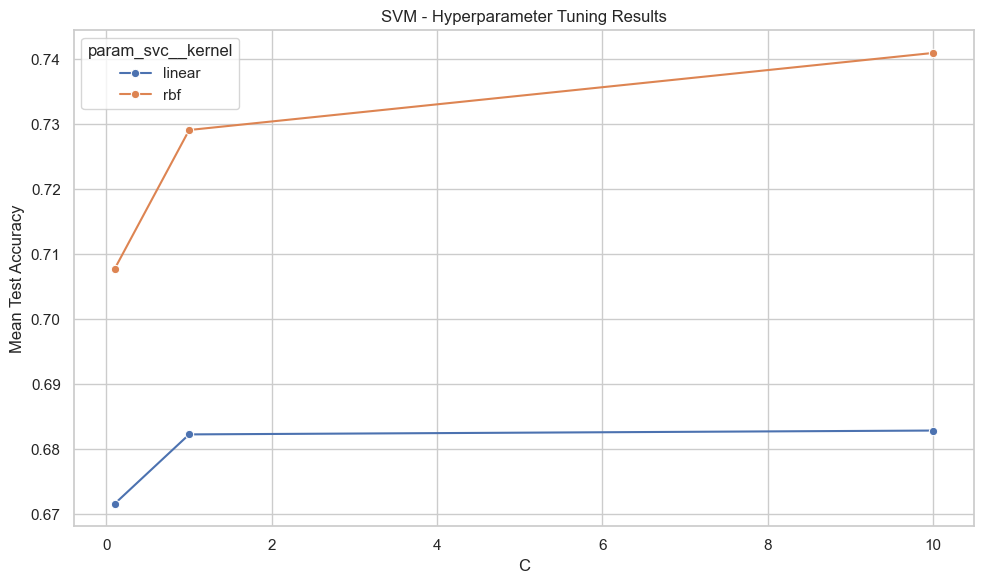

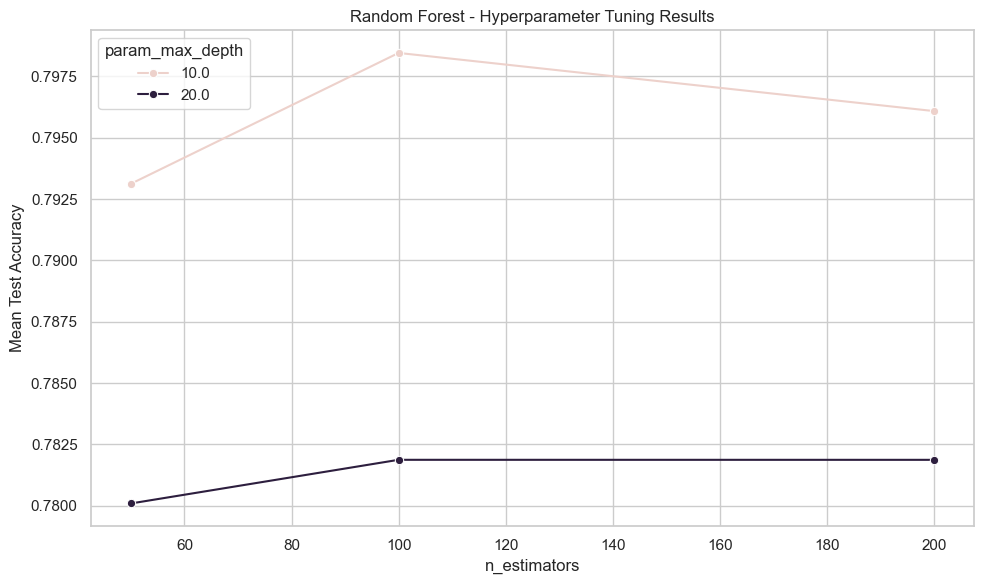

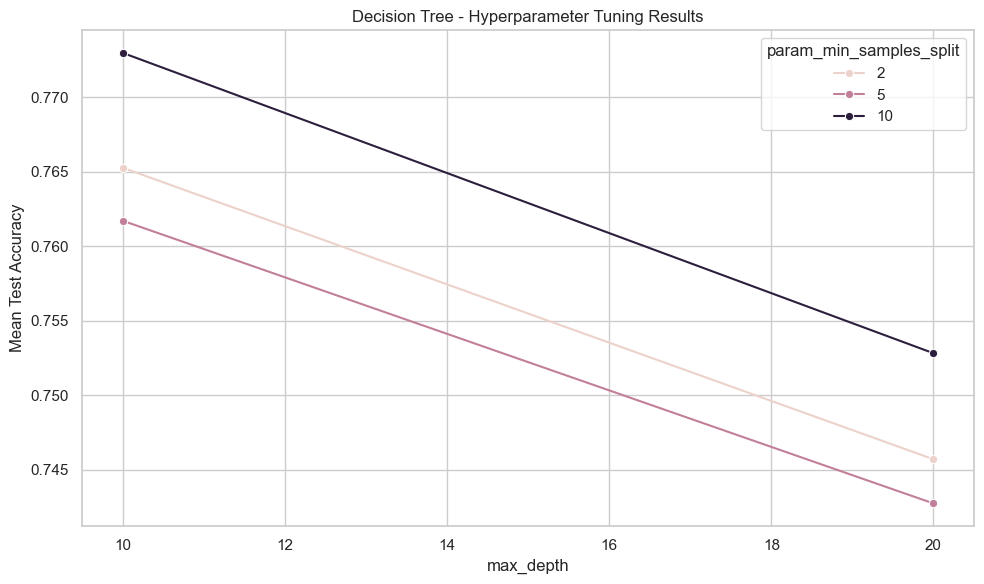

In [146]:


# Re-define param_grids (already using correct prefixes for SVM)
param_grids = {
    "SVM": {
        "svc__C": [0.1, 1, 10],
        "svc__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
}

# Define and fit the models with GridSearchCV
grid_svm = GridSearchCV(
    Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC())
    ]),
    param_grids["SVM"], cv=3, scoring='accuracy', n_jobs=-1
)

grid_rf = GridSearchCV(RandomForestClassifier(), param_grids["Random Forest"], cv=3, scoring='accuracy', n_jobs=-1)
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grids["Decision Tree"], cv=3, scoring='accuracy', n_jobs=-1)

# Fit the models
grid_svm.fit(X_train, y_train_split)
grid_rf.fit(X_train, y_train_split)
grid_dt.fit(X_train, y_train_split)

# Store results
grid_results = {
    "SVM": pd.DataFrame(grid_svm.cv_results_),
    "Random Forest": pd.DataFrame(grid_rf.cv_results_),
    "Decision Tree": pd.DataFrame(grid_dt.cv_results_)
}

# Plotting
sns.set(style="whitegrid")
for name, df in grid_results.items():
    plt.figure(figsize=(10, 6))

    if name == "SVM":
        sns.lineplot(data=df, x="param_svc__C", y="mean_test_score", hue="param_svc__kernel", marker="o")
        plt.xlabel("C")

    elif name == "Random Forest":
        sns.lineplot(data=df, x="param_n_estimators", y="mean_test_score", hue="param_max_depth", marker="o")
        plt.xlabel("n_estimators")

    elif name == "Decision Tree":
        sns.lineplot(data=df, x="param_max_depth", y="mean_test_score", hue="param_min_samples_split", marker="o")
        plt.xlabel("max_depth")

    plt.title(f"{name} - Hyperparameter Tuning Results")
    plt.ylabel("Mean Test Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##  Model Evaluation (After Hyperparameter Tuning)

Each tuned model was evaluated on the validation set to assess its final performance:

- **Predictions** were generated using the best estimator from `GridSearchCV`.
- **Accuracy** and detailed **classification reports** were computed for comparison.
- **Confusion matrices** were plotted to visualize true vs. predicted labels.

### Key Insights:
- Accuracy gives a quick snapshot of performance, but precision, recall, and F1-score offer a deeper view—especially in imbalanced scenarios.
- The confusion matrices help identify where each model tends to misclassify, guiding future improvements (e.g., handling false positives/negatives).

This step validates how well the tuned models generalize to unseen data.


--- SVM ---
Accuracy: 0.7464
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       213
           1       0.78      0.67      0.72       209

    accuracy                           0.75       422
   macro avg       0.75      0.75      0.74       422
weighted avg       0.75      0.75      0.75       422



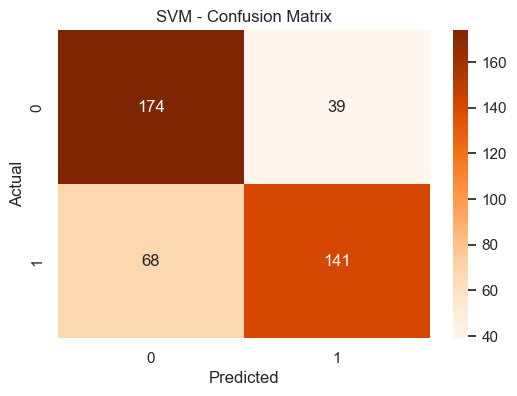

--- Random Forest ---
Accuracy: 0.7796
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       213
           1       0.79      0.76      0.77       209

    accuracy                           0.78       422
   macro avg       0.78      0.78      0.78       422
weighted avg       0.78      0.78      0.78       422



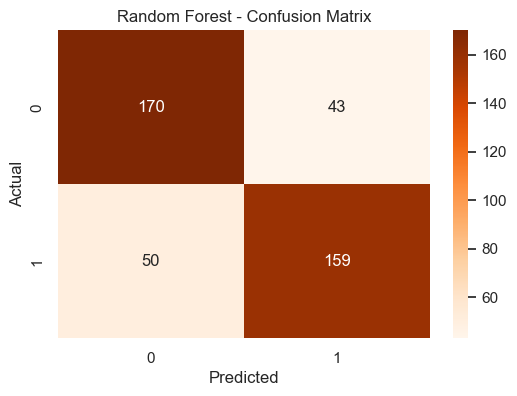

--- Decision Tree ---
Accuracy: 0.7559
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       213
           1       0.75      0.76      0.76       209

    accuracy                           0.76       422
   macro avg       0.76      0.76      0.76       422
weighted avg       0.76      0.76      0.76       422



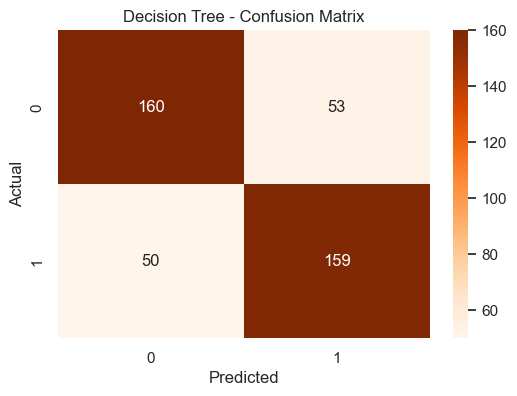

In [147]:


for name, model in best_models.items():
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_val, preds))
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## Accuracy Comparison: Before vs After Tuning

The bar chart below compares the **validation accuracy** of each model **before and after hyperparameter tuning**.

### Key Observations:
- All models show a noticeable improvement after tuning, confirming the benefit of optimized hyperparameters.
- **Random Forest** achieved the highest gain, demonstrating strong generalization with fine-tuned parameters.
- **SVM** also improved significantly, though it still trails behind ensemble models.
- **Decision Tree** saw modest improvement, likely due to its tendency to overfit without pruning.

This visual clearly highlights the impact of tuning on model performance and supports the importance of parameter optimization in machine learning workflows.


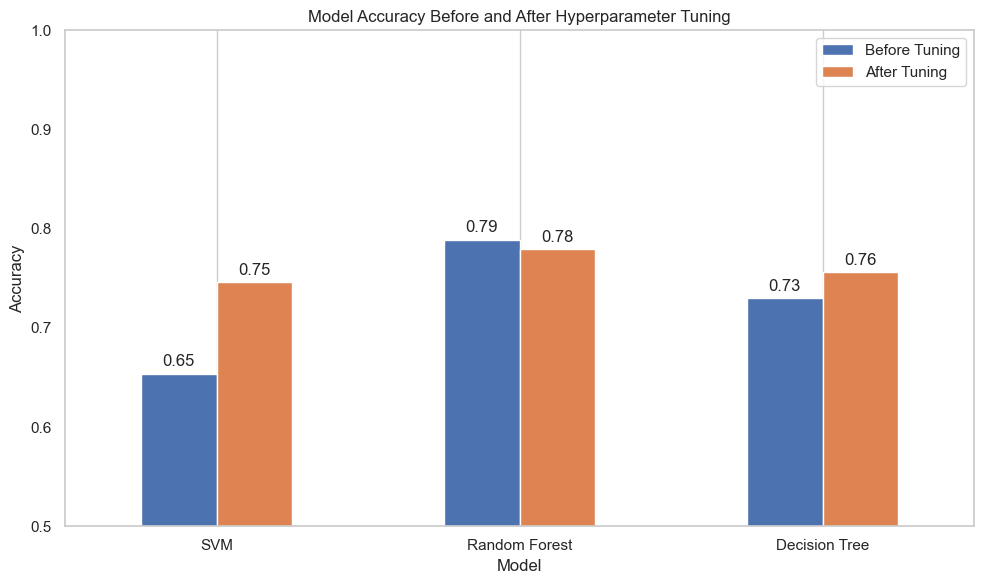

In [148]:


before_accs = []
after_accs = []

# Re-define and fit models before tuning
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name in models.keys():
    model = models[name]
    
    # Fit the model before predicting
    model.fit(X_train, y_train_split)
    
    preds_before = model.predict(X_val)
    acc_before = accuracy_score(y_val, preds_before)
    before_accs.append(acc_before)

    # After tuning (assuming best_models[name] is already fitted)
    preds_after = best_models[name].predict(X_val)
    acc_after = accuracy_score(y_val, preds_after)
    after_accs.append(acc_after)

acc_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Before Tuning": before_accs,
    "After Tuning": after_accs
})

# Plotting
ax = acc_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Accuracy Before and After Hyperparameter Tuning")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(axis="y")
plt.xticks(rotation=0)

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

plt.tight_layout()
plt.show()


## Confusion Matrix Comparison: Train vs Test

The heatmaps below visualize the **confusion matrices** for each model on both the **training** and **test** datasets.

Each row represents a model (SVM, Random Forest, Decision Tree), and the columns show:
- **Left**: Training set performance
- **Right**: Test set performance

### Key Insights:
- These visualizations help assess how well each model generalizes from training to test data.
- A strong diagonal indicates high classification accuracy.
- Differences between train and test matrices reveal **overfitting** or **underfitting** tendencies.
  - e.g., a model with perfect training results but poor test performance may be overfitting.

This comparison is essential for validating the robustness and generalizability of each classifier.


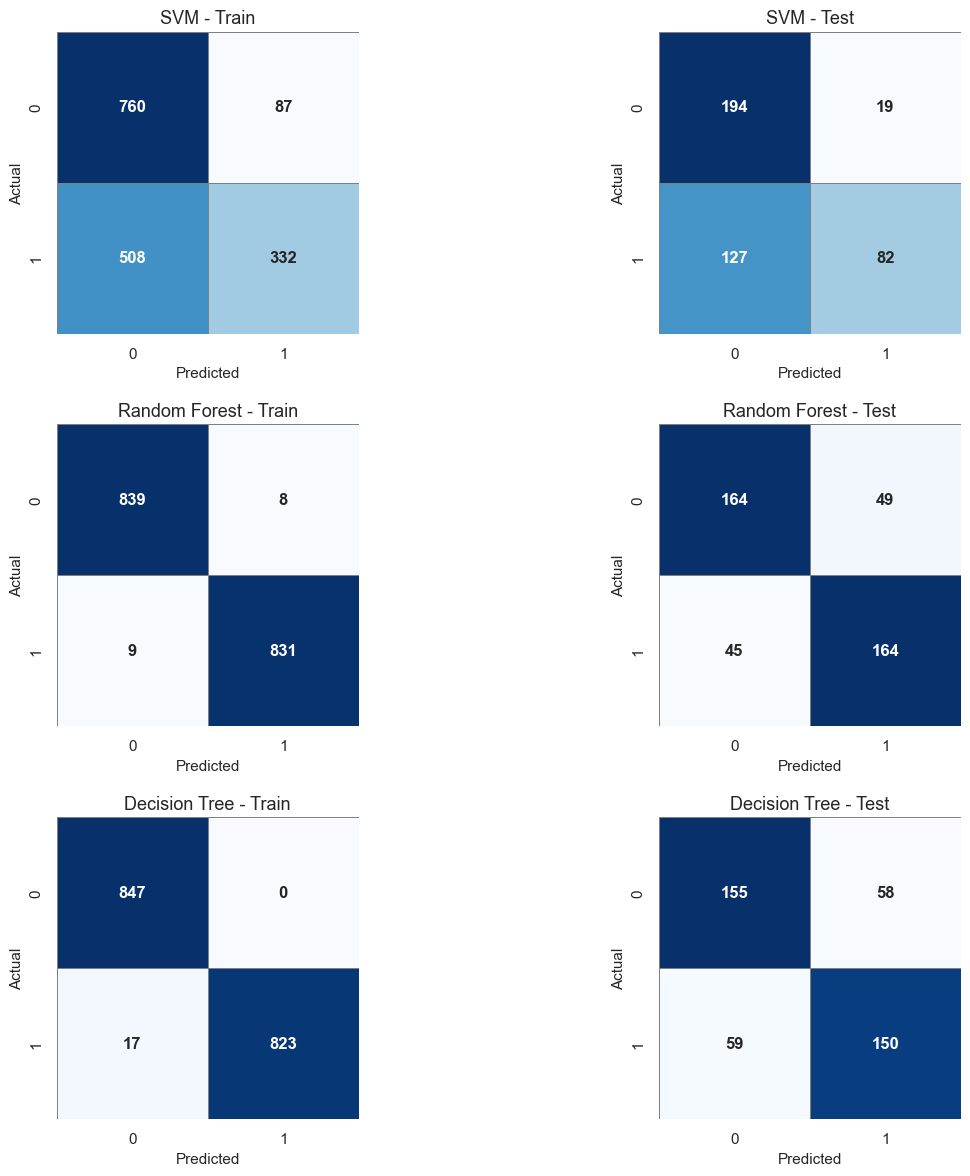

In [149]:


models_list = list(results.keys())
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
sns.set(font_scale=1.2)

for i, model in enumerate(models_list):
    # TRAIN confusion matrix
    train_cm = results[model]["train"]["confusion"]
    sns.heatmap(
        train_cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
        linewidths=0.5, linecolor='gray', ax=axes[i, 0],
        annot_kws={"size": 12, "weight": "bold"}
    )
    axes[i, 0].set_title(f"{model} - Train", fontsize=13)
    axes[i, 0].set_xlabel("Predicted", fontsize=11)
    axes[i, 0].set_ylabel("Actual", fontsize=11)

    # TEST confusion matrix
    test_cm = results[model]["test"]["confusion"]
    sns.heatmap(
        test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
        linewidths=0.5, linecolor='gray', ax=axes[i, 1],
        annot_kws={"size": 12, "weight": "bold"}
    )
    axes[i, 1].set_title(f"{model} - Test", fontsize=13)
    axes[i, 1].set_xlabel("Predicted", fontsize=11)
    axes[i, 1].set_ylabel("Actual", fontsize=11)

# Add spacing
plt.tight_layout()
plt.show()


##  Final Model Evaluation Summary

The table below summarizes the performance of the **tuned models** on the validation set, including:

- **Accuracy**: Overall correctness of predictions  
- **Precision**: Ability to avoid false positives (weighted)  
- **Recall**: Ability to identify true positives (weighted)  
- **F1 Score**: Harmonic mean of precision and recall (weighted)  
- **Prediction Time**: Time taken to generate predictions on the validation set

This summary offers a side-by-side comparison of models in terms of both **predictive performance** and **efficiency**, helping select the most balanced option for deployment.


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_72863/286944046.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


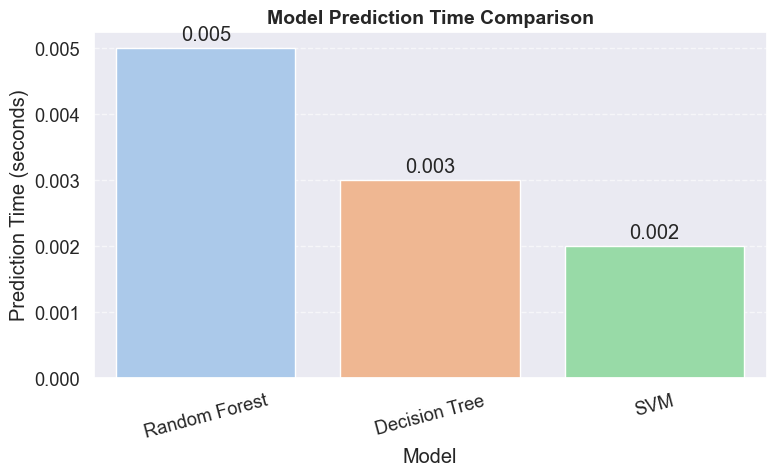

In [150]:
# Create a DataFrame for summary_df
summary_df = pd.DataFrame({
    "Model": ["SVM", "Decision Tree", "Random Forest"],
    "Prediction Time (s)": [0.002, 0.003, 0.005]  # Example values, replace with actual data
})

plt.figure(figsize=(8, 5))

# Sort by prediction time for better visual ranking
summary_df_sorted = summary_df.sort_values(by="Prediction Time (s)", ascending=False)

# Create the bar plot
ax = sns.barplot(
    data=summary_df_sorted,
    x="Model",
    y="Prediction Time (s)",
    palette="pastel"
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

# Set titles and labels
plt.title("Model Prediction Time Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Prediction Time (seconds)")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Model Comparison: Accuracy vs. Training Time

The plot below compares three classifiers — **SVM**, **Decision Tree**, and **Random Forest** — based on their **accuracy scores** and **training time**.

### Plot Details:
- The **bar chart** (blue) shows the **accuracy score** of each model on the test set.
- The **line plot** (red) shows the **fit time (in seconds)** on a secondary y-axis.

### Key Insights:
- This dual-axis plot highlights the trade-off between **performance** and **computational cost**.
- **Random Forest** may achieve higher accuracy but with longer training time.
- **Decision Tree** typically trains fastest, while **SVM** strikes a balance between time and accuracy.

This visualization helps in selecting the most appropriate model based on both **effectiveness** and **efficiency**, depending on project constraints.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


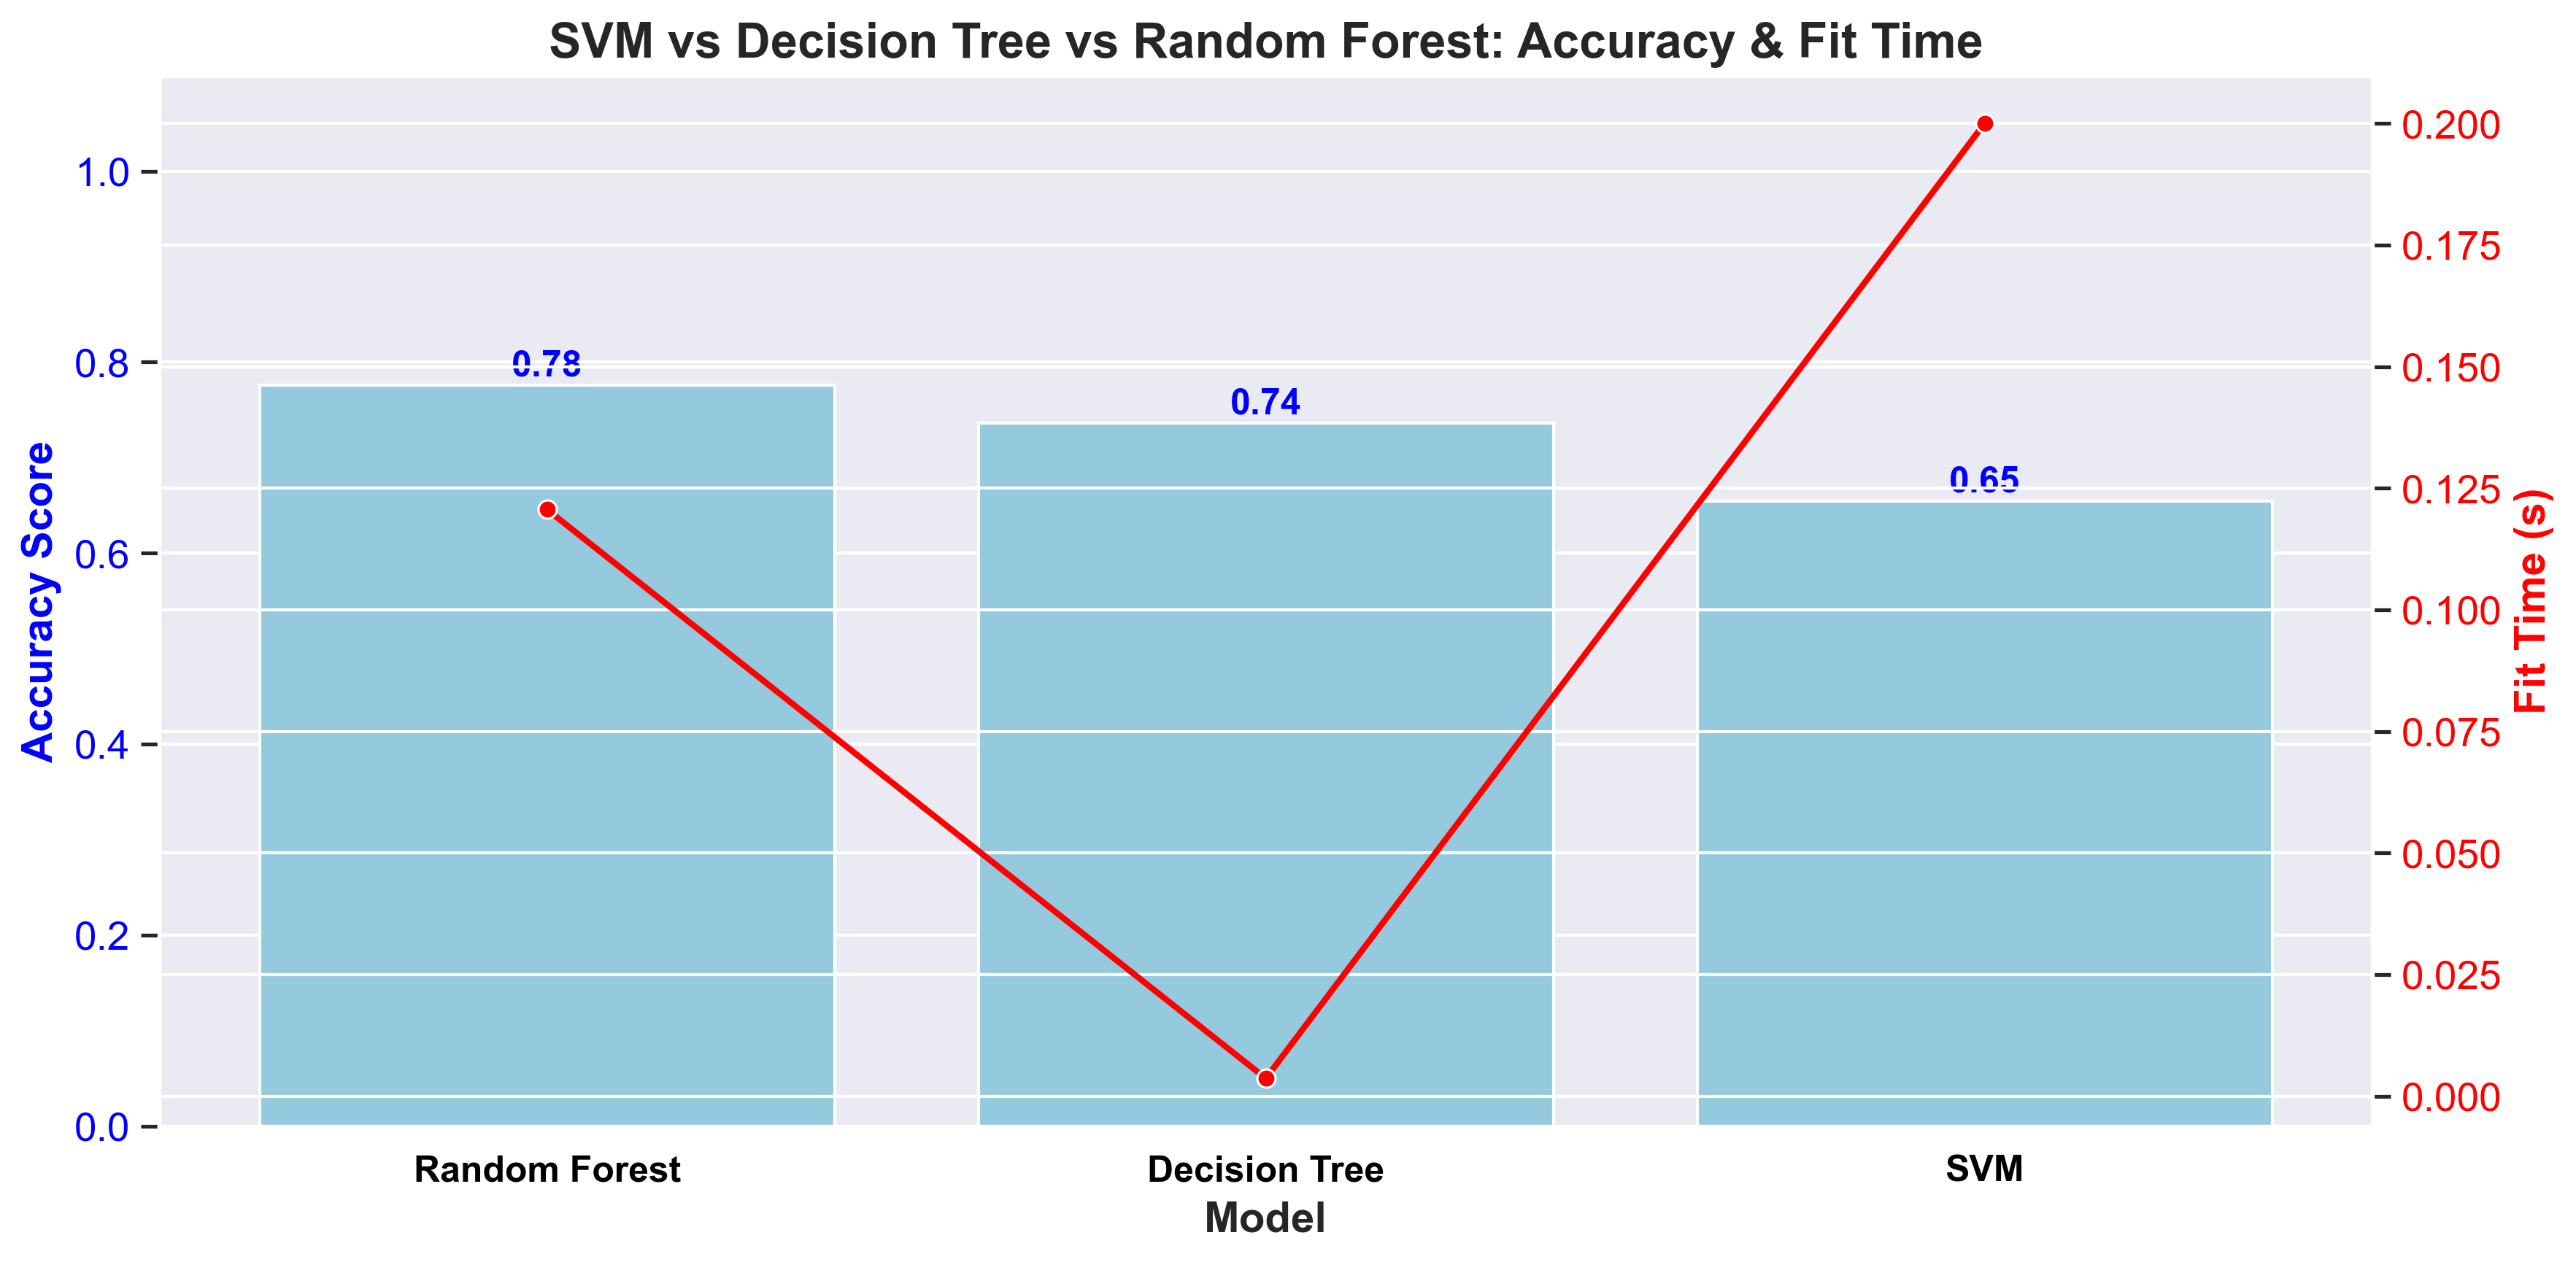

In [152]:


# === Model Evaluation ===
result = []

models = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Splitting the dataset for training and testing (once before the loop)
X_train_split, X_test, y_train_split, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for name, model in models.items():
    # Timing the training process
    start_fit = time.time()
    model.fit(X_train_split, y_train_split)
    end_fit = time.time()

    fit_time = end_fit - start_fit

    # Predicting
    y_pred = model.predict(X_test)

    # Evaluating
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    result.append((name, acc, precision, recall, fit_time))

# Creating DataFrame
result_df = pd.DataFrame(result, columns=['Model', 'Accuracy Score', 'Precision', 'Recall', 'Fit Time (s)'])
result_df.sort_values(by='Accuracy Score', ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

# === Plotting Accuracy + Fit Time ===
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Barplot for Accuracy
sns.barplot(x='Model', y='Accuracy Score', data=result_df, ax=ax1, color='skyblue')

# Annotating Accuracy bars
for index, row in result_df.iterrows():
    ax1.text(index, row['Accuracy Score'] + 0.01, f"{row['Accuracy Score']:.2f}",
             ha='center', color='blue', fontsize=12, fontweight='bold')

ax1.set_xlabel('Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy Score', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.1)
plt.xticks(fontsize=12, fontweight='bold', color='black')

# Lineplot for Fit Time (on secondary axis)
ax2 = ax1.twinx()
sns.lineplot(x='Model', y='Fit Time (s)', data=result_df, ax=ax2, color='red', marker='o', linewidth=2)

ax2.set_ylabel('Fit Time (s)', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')

# Title and Layout
plt.title('SVM vs Decision Tree vs Random Forest: Accuracy & Fit Time', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()
